# Set Required Args to Activate Modules

In [1]:
import RES.RESources as RES

 └> Using CODERS API key: w0OksqQKMFMtKPbO


- All steps are integrated in this 'RES_module.build()' method.

In [2]:
# Iterate over provinces for both solar and wind resources
resource_types = ['wind',]  # 'solar'
provinces=['BC']  #,'AB','SK','ON','NS','MB'
for province_code in provinces:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config_CAN.yaml',
            "region_short_code": province_code,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        # RES_module.build(select_top_sites=True,
        #                  use_pypsa_buses=False)
        

____________________________________________________________
     Initiating RESource Builder | RES.RESources
____________________________________________________________
 └> NREL_ATBProcessor initiated...
  └> RES.atb| Processing Annual Technology Baseline (ATB) data sourced from NREL...
 └> RES.utility| Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.
  └> RES.atb| ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'
 └> Snapshot for Resources: 2023-01-01 07:00

# Stepwise Checks/Debugging [when required]

<img src="docs/source/_static/assessment_steps.jpg" alt="assessment_steps" width="400"/>

<img src="docs/source/_static/high_level_workflow.jpg" alt="high_level_workflow" width="900"/>

### Step 1: Prepare Spatial Grid Cells

- This method collects the sub-national administrative boundaries. 
- Using that boundary, we calculate the Minimum Bounding Rectangle (MBR). 
- We use that MBR as a cutout to source weather resources data from ERA5 via CDSAPI. The ERA5's cutout is then stored as a netcdf `.nc' file.
- We load that cutout as `atlite`'s `cutout` object.
- We then use `atlite`'s `cutout.grid` attribute to create our test beds for the analysis i.e. the grid cells (geodataframe)

In [3]:
data1=RES_module.get_grid_cells()

data1.head(5) # See the first 5 rows of the grid cells data

2025-07-14 11:09:00,649 - INFO - Storing temporary files in /tmp/tmpy8fodek9


 └> RES.RESources| Preparing Grid Cells...
  └─> RES.era5_cutout|  Processing ERA5's cutout...
  └─> RES.boundaries| Processing regional bounding box...
  └─> RES.boundaries| Region Set to >> Short Code : BC, Name: British Columbia).
  └─> RES.boundaries| Collecting regional boundary...
  └─> RES.boundaries| Loading GADM boundaries (Sub-provincial | level =2) for British Columbia from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
  └─> RES.boundaries| Setting up the Minimum Bounding Region (MBR) for BC...
  └─> RES.era5_cutout| ✓ MBR and regional boundary created. 
ℹ️   Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related

,x,y,Country,Province,Region,geometry
cell,,,,,,
Capital_-123.75_48.25,-123.75,48.25,Canada,British Columbia,Capital,"MULTIPOLYGON (((-123.625 48.32983, -123.6294 4..."
Capital_-123.5_48.25,-123.50,48.25,Canada,British Columbia,Capital,"MULTIPOLYGON (((-123.625 48.375, -123.52298 48..."
CowichanValley_-124.75_48.5,-124.75,48.50,Canada,British Columbia,CowichanValley,"POLYGON ((-124.625 48.625, -124.625 48.56944, ..."
Capital_-124.5_48.5,-124.50,48.50,Canada,British Columbia,Capital,"POLYGON ((-124.375 48.625, -124.375 48.51105, ..."
CowichanValley_-124.5_48.5,-124.50,48.50,Canada,British Columbia,CowichanValley,"POLYGON ((-124.625 48.625, -124.48926 48.625, ..."


### Step 2: Calculate Potential Capacity

- This method loads the cutout (atlite's cutout object), regional boundary (GeoDataFrame), loads the cost parameters and  also initiates a __composite excluder__
  - The ([`atlite`'s exclusion container](https://atlite.readthedocs.io/en/master/ref_api.html#atlite.Cutout.availabilitymatrix)) to merge all the spatial layers.
- the `cutout.availabilitymatrix` method calculates % of usable area within each grid cell after applying exclusion criteria (e.g., protected areas, water bodies) and returns an [`AvaliabilityMatrix`](https://atlite.readthedocs.io/en/master/ref_api.html#atlite.Cutout.availabilitymatrix)
- We apply technology landuse intensity (e.g., MW/km² for wind or solar) to translate this to potential capacity data.
- We get the maximum installable capacity for each grid cell based on available area, land use constraints, and technology-specific parameters.
  > - Current results gives a percentage of availability for each grid cell. It does not tell specifically which spatial area inside a grid cell is unavailable.
  > - The _potential capacity_ translation processing involves `area` calculation. The area calculation method is integrated to `RES.cell_processor.get_capacity()`. That method is sensitive to area calculation specific coordinate-system projection of the geodataframe. It is recommended to be cautious about choosing this crs.
  

2025-07-14 11:09:01,222 - INFO - Storing temporary files in /tmp/tmp9gzsnon4


 └> RES.RESources| Preparing Cells' capacity...
  └> RES.CellCapacityProcessor| Cell capacity processor initiated...
  └─> RES.era5_cutout|  Processing ERA5's cutout...
  └─> RES.boundaries| Processing regional bounding box...
  └─> RES.boundaries| Region Set to >> Short Code : BC, Name: British Columbia).
  └─> RES.boundaries| Collecting regional boundary...
  └─> RES.boundaries| Loading GADM boundaries (Sub-provincial | level =2) for British Columbia from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
  └─> RES.boundaries| Setting up the Minimum Bounding Region (MBR) for BC...
  └─> RES.era5_cutout| ✓ MBR and regional boundary created. 
ℹ️   Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic infor

  └─> RES.gaez| Clipped Raster plot for British Columbia saved at: vis/misc/slpmed05_raster_BC.png
  └─> RES.gaez| Clipped Raster plot for British Columbia saved at: vis/misc/exclusion_2017_raster_BC.png
  └─> RES.gaez| ✔ All required rasters for GAEZ processed and plotted successfully.
  └> RES.lands| Loading Land_cover layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/lco/BC_faocmb_2010.tif
  └> RES.lands| Loading Terrain_resources layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/ter/BC_slpmed05.tif
  └> RES.lands| Loading Exclusion_areas layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/excl/BC_exclusion_2017.tif
  └─> RES.lands| ✔ Exclusion_areas loaded to exclusion container
  └─> RES.lands| ✔ Exclusion_areas loaded to exclusion container
  └─> RES.lands| ✔ Exclusion_areas loaded to exclusion container
  └─> RES.lands| Loading Conserved areas for British Columbia
  └─> RES.lands| Processing Conserved areas for British Columbia
 └> RES.lands| Loading Canadian Pro

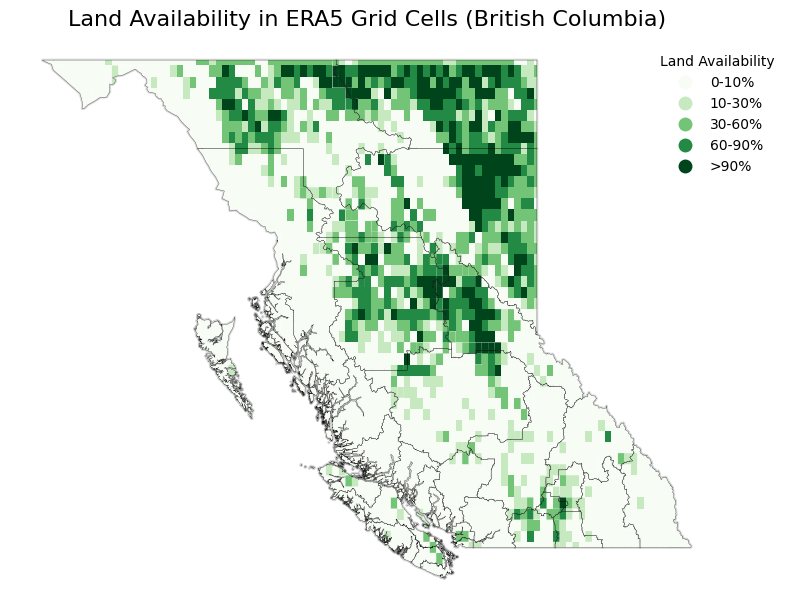

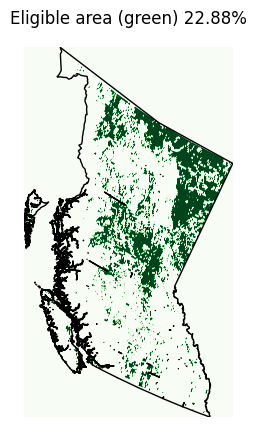

In [4]:
data2=RES_module.get_cell_capacity()

In [5]:
print(data2._fields)


('data', 'matrix')


### Step 3: Get CF and Windspeed from Higher Resolution Data

> - Currently configured for Wind Resources only. Wind resources (windspeed) are known to have significant variations across ERA5's ~30km resolution. We rescaled the windspeed with higher resolution windspeed from Global Wind Atlas (GWA). Then we calculate the ERA5 scaled windspeed from the mapped GWA cells. However, GWA does not provide hourly profiles. We source the profile from ERA5.

- returns NONE if result datafield ('windspeed_ERA5') is already there 

In [6]:
gwa_cells=RES_module.gwa_cells.load_gwa_cells()

  └─> RES.boundaries| Processing regional bounding box...
  └─> RES.boundaries| Region Set to >> Short Code : BC, Name: British Columbia).
  └─> RES.boundaries| Collecting regional boundary...
  └─> RES.boundaries| Loading GADM boundaries (Sub-provincial | level =2) for British Columbia from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
  └─> RES.boundaries| Setting up the Minimum Bounding Region (MBR) for BC...
  └─> RES.gwa| 46770000 cells have been filtered due to Windspeed filter [0-50 m/s].
>>> Cleaned data loaded for 34534034 GWA cells
  └─> RES.boundaries| Region Set to >> Short Code : BC, Name: British Columbia).
  └─> RES.boundaries| Collecting regional boundary...
  └─> RES.boundaries| Loading GADM boundaries (Sub-provincial | level =2) for British Columbia from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
  └> RES.gwa| Global Wind Atlas (GWA) Cells loaded. Size: 34534034


### GWA Scaled Wind Speed vs ERA5 Windspeed Comparison

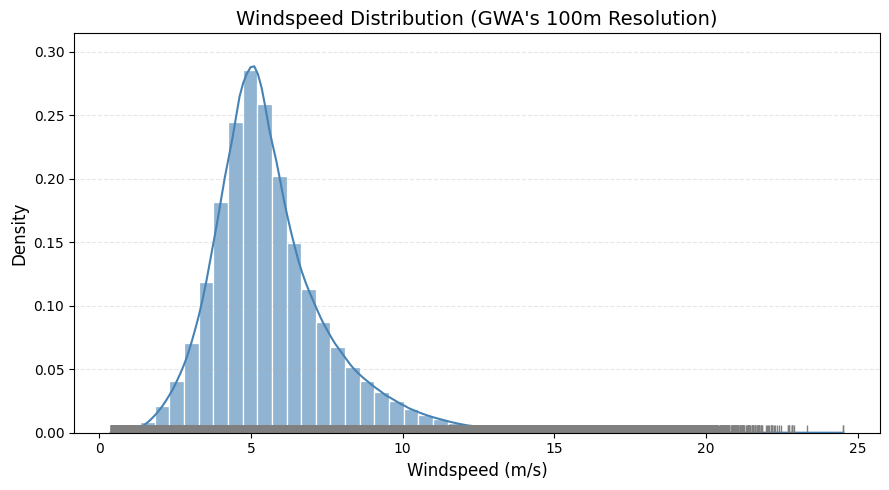

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 5))
sns.histplot(gwa_cells['windspeed_gwa'], bins=50, kde=True, color='steelblue', edgecolor='white', stat='density', alpha=0.6,legend=True)
sns.rugplot(gwa_cells['windspeed_gwa'], color='grey', height=0.02)

plt.title('Windspeed Distribution (GWA\'s 100m Resolution)', fontsize=14)
plt.xlabel('Windspeed (m/s)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(f'vis/{province_code}/gwa_resolution_windspeed_distribution_{province_code}.jpg', dpi=300)
plt.show()

In [11]:
data3=RES_module.extract_weather_data()

2025-07-14 11:12:46,682 - INFO - Storing temporary files in /tmp/tmpqa_clxhw


 └> RES.RESources| Extracting ERA5 windspeed from cutout...
  └─> RES.era5_cutout|  Processing ERA5's cutout...
  └─> RES.boundaries| Processing regional bounding box...
  └─> RES.boundaries| Region Set to >> Short Code : BC, Name: British Columbia).
  └─> RES.boundaries| Collecting regional boundary...
  └─> RES.boundaries| Loading GADM boundaries (Sub-provincial | level =2) for British Columbia from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
  └─> RES.boundaries| Setting up the Minimum Bounding Region (MBR) for BC...
  └─> RES.era5_cutout| ✓ MBR and regional boundary created. 
ℹ️   Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more o

In [12]:
data4=RES_module.update_gwa_scaled_params() # testing, 2025 04 21

  └> RES.RESources| Preparing high resolution windspeed data from Global Wind Atlas
  └─> RES.RESources| 'CF_IEC2', 'CF_IEC3', 'windspeed_gwa' are already present in the store information, skipping data extraction from source


In [13]:
data4.head(5) # See the first 5 rows of the updated grid cells data with weather resources

,x_1,y_1,windspeed_gwa,CF_IEC2,CF_IEC3,x,y,potential_capacity_wind,capex_wind,fom_wind,...,capex_solar,fom_solar,vom_solar,grid_connection_cost_per_km_solar,tx_line_rebuild_cost_solar,Operational_life_solar,solar_CF_mean,lcoe_solar,Province_1,Province_2
cell,,,,,,,,,,,,,,,,,,,,,
Stikine_-132.25_58.5,-132.250927,58.500769,5.301389,0.231283,0.251572,-132.25,58.50,0.129595,1.564557,0.0,...,1.366598,0.0,0.0238,2.6,0.56,25.0,0.173333,69.786214,British Columbia,British Columbia
Stikine_-133.25_59.75,-133.250927,59.750769,6.724553,0.333039,0.358939,-133.25,59.75,0.166965,1.564557,0.0,...,1.366598,0.0,0.0238,2.6,0.56,25.0,0.188441,96.458113,British Columbia,British Columbia
Stikine_-133.25_59.25,-133.250927,59.250769,5.170671,0.217921,0.240807,-133.25,59.25,0.310741,1.564557,0.0,...,1.366598,0.0,0.0238,2.6,0.56,25.0,0.173554,165.774147,British Columbia,British Columbia
Stikine_-132.75_59.75,-132.750927,59.750769,6.109521,0.297671,0.324184,-132.75,59.75,0.216301,1.564557,0.0,...,1.366598,0.0,0.0238,2.6,0.56,25.0,0.183823,1688.746265,British Columbia,British Columbia
PeaceRiver_-125.0_57.25,-125.000927,57.250769,3.897013,0.131210,0.146785,-125.00,57.25,0.637751,1.564557,0.0,...,1.366598,0.0,0.0238,2.6,0.56,25.0,0.195933,53.010173,British Columbia,British Columbia


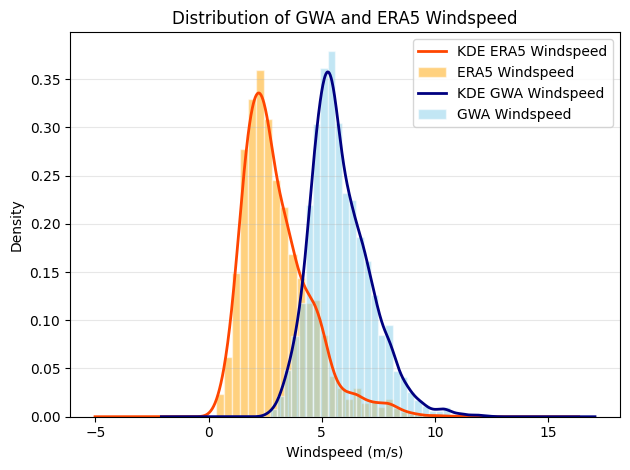

In [ ]:
import matplotlib.pyplot as plt

data4['windspeed_ERA5'].plot.kde(color='orangered', linewidth=2, label='KDE ERA5 Windspeed')
data4['windspeed_ERA5'].plot.hist(bins=30, color='orange', edgecolor='white', density=True, alpha=0.5, label='ERA5 Windspeed')
data4['windspeed_gwa'].plot.kde(color='navy', linewidth=2, label='KDE GWA Windspeed')
data4['windspeed_gwa'].plot.hist(bins=30, color='skyblue', edgecolor='white', density=True, alpha=0.5, label='GWA Windspeed')

plt.title('Distribution of GWA and ERA5 Windspeed')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f'vis/{province_code}/ERA5_resolution_windspeed_distribution_ERA5vsGWA_{province_code}.png', dpi=300)
plt.show()

### Step 4: Get Timeseries

- We define technology attributes.
- We extract timeseries using weather resources data from ERA5's cutout.
  - The timeseries calculation method currently configured with [atlite.cutout.pv](https://atlite.readthedocs.io/en/master/ref_api.html#atlite.Cutout.pv) and [atlite.cutout.wind](https://atlite.readthedocs.io/en/master/ref_api.html#atlite.Cutout.wind) methods.

> __Attention__
  > - Configure the timezone conversion information carefully to ensure proper usage of the timeseries in downstream modelling. 
  > - ERA5 provides naive timezone index data. We use the timezone information from config file to enable the timezone shift of the timeseries.
  > - However, after conversion we removed the timezone awareness from the datetime index to harmonize with pypsa supported timeseries index.

In [30]:
data5=RES_module.get_CF_timeseries()

2025-07-14 12:02:01,472 - INFO - >> Loading ERA5 Cutout
2025-07-14 12:02:01,536 - INFO - Storing temporary files in /tmp/tmpiv2bc18_
2025-07-14 12:02:01,538 - INFO - >> 2948 Grid Cells from Store Cutout


  └─> RES.RESources| Preparing Timeseries for the Cells...
  └─> RES.era5_cutout|  Processing ERA5's cutout...
  └─> RES.boundaries| Processing regional bounding box...
  └─> RES.boundaries| Region Set to >> Short Code : BC, Name: British Columbia).
  └─> RES.boundaries| Collecting regional boundary...
  └─> RES.boundaries| Loading GADM boundaries (Sub-provincial | level =2) for British Columbia from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
  └─> RES.boundaries| Setting up the Minimum Bounding Region (MBR) for BC...
  └─> RES.era5_cutout| ✓ MBR and regional boundary created. 
ℹ️   Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more op

2025-07-14 12:06:46,487 - INFO - adding a cut-out wind speed to the turbine power curve at V=22.0 m/s.
2025-07-14 12:06:46,487 - INFO - Convert and aggregate 'wind'.


 └> RES.timeseries| Loading technology attributes...
Fetching Turbine: '3.2M114_NES' data from OEDB
>> Loading turbine config from: data/downloaded_data/OEDB/3.2M114_NES.yaml
>> selected Wind Turbine  Model : 3.2M114 NES @ 93.0m Hub Height
 └> RES.timeseries| ⚠️ Processing timeseries from ERA5 cutout, may take a while...
 └> RES.timeseries| Harmonizing timezone for British Columbia with Etc/GMT+7
 └> RES.timeseries| Calculating CF mean from the 8760 data points for each Cell ...
  └> RES.timeseries| Total Grid Cells: 2948
  └> RES.timeseries| Timeseries Generated for: 2948
  └> RES.timeseries| Matched Sites: (8760, 2948)
  └> RES.hdf5_handler| 💾 Updated 'cells' saved to data/store/resources_BC.h5 with key 'cells'
  └> RES.hdf5_handler| 💾 Updated 'timeseries/wind' saved to data/store/resources_BC.h5 with key 'timeseries/wind'


### Step 5: Find Grid Proximity

This information is critical for downstream operational analysis with this resource options.

> - Currently configured for Transmission Lines and/or Grid Substations.
> - We do not know the specific project point of a resource. Hence, the resource to grid-node distance has been calculated from the centroid of each grid to the grid node. 
> - If you have a specific project point, you should recalculate this distance with your specific project point.


- Identifies and assigns grid nodes to each cell. 
- Calculates distance (in km) from each grid cell to the nearest grid node (e.g., transmission line, substation) to assess connectivity and feasibility for energy transport.
    
    > If your use case of the resource options are to be plugged in to a downstream operational model (e.g. PyPSA), use harmonized nodes to populate this data.
    > harmonized nodes i.e. same data that are intended to be used as _bus_ nodes at your operational model. 


In [31]:
data6=RES_module.find_grid_nodes()

 └> RES.RESources| Grid Node Location initiated...
  └─> RES.RESources| Using Substations (sourced from CODERS) preferred nodes for resource connection.


2025-07-14 12:10:47,544 - INFO - >> Data pulled substations from [source checked: CODERS(https://sesit.dev/api/docs)]
2025-07-14 12:10:47,548 - INFO - substations data saved to:
 data/downloaded_data/CODERS/network/substations.pkl
2025-07-14 12:10:47,668 - INFO - Storing temporary files in /tmp/tmpelpyuyab
2025-07-14 12:10:47,674 - INFO - > Calculating Nearest Grid Nodes for Grid Cells


  └─> RES.era5_cutout|  Processing ERA5's cutout...
  └─> RES.boundaries| Processing regional bounding box...
  └─> RES.boundaries| Region Set to >> Short Code : BC, Name: British Columbia).
  └─> RES.boundaries| Collecting regional boundary...
  └─> RES.boundaries| Loading GADM boundaries (Sub-provincial | level =2) for British Columbia from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
  └─> RES.boundaries| Setting up the Minimum Bounding Region (MBR) for BC...
  └─> RES.era5_cutout| ✓ MBR and regional boundary created. 
ℹ️   Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://a

2025-07-14 12:10:47,847 - INFO - ERA5 Cells Filtered based on Proximity to Tx Nodes 
Size: 1882



  └─> RES.RESources| ✔ Closest grid nodes and distance calculation completed.
  └> RES.hdf5_handler| 💾 Updated 'cells' saved to data/store/resources_BC.h5 with key 'cells'
  └> RES.hdf5_handler| 💾 Updated 'substations' saved to data/store/resources_BC.h5 with key 'substations'


### Step 6: Scoring Metric to Rank the Sites

- Scores each grid cell based on multiple criteria (e.g., resource quality, proximity to grid), supporting site selection.

In [45]:
data7=RES_module.score_cells()

  └─> RES.score| Calculating score for cells...
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cells'


### Step 7: Clusterized Representation of the Sites

- Groups grid cells into clusters based on spatial or resource characteristics to enable aggregated analysis.
- Produces time series data for each cluster, summarizing the resource and capacity factor information at the cluster leve

In [46]:
data8=RES_module.get_clusters()
data9=RES_module.get_cluster_timeseries()

 └> RES.RESources| Preparing cluster of resources...
  └> RES.RESources| Clustering requires scored cells. The default scoring method is set to 'lcoe'. Checking for 'lcoe' in datafields...
  └─> RES.RESources| 'lcoe_wind' not found in available datafields...


  └─> RES.score| Calculating score for cells...
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cells'

=== Processing region: Stikine ===
Available columns in cells_scored: ['x_1', 'y_1', 'windspeed_gwa', 'CF_IEC2', 'CF_IEC3', 'x', 'y', 'potential_capacity_wind', 'capex_wind', 'fom_wind', 'vom_wind', 'grid_connection_cost_per_km_wind', 'tx_line_rebuild_cost_wind', 'Operational_life_wind', 'windspeed_ERA5', 'Country', 'Province', 'Region', 'geometry', 'wind_CF_mean', 'nearest_station', 'nearest_station_distance_km', 'lcoe_wind', 'potential_capacity_solar', 'capex_solar', 'fom_solar', 'vom_solar', 'grid_connection_cost_per_km_solar', 'tx_line_rebuild_cost_solar', 'Operational_life_solar', 'solar_CF_mean', 'lcoe_solar', 'Province_1', 'Province_2']
Data before imputation:
          lcoe_wind  potential_capacity_wind
count    430.000000               430.000000
mean     838.293503               291.140491
std     3380.359433              

2025-07-14 12:11:14,190 - INFO -  Creating cluster for Stikine 1/28
2025-07-14 12:11:14,213 - INFO -  Creating cluster for PeaceRiver 2/28
2025-07-14 12:11:14,232 - INFO -  Creating cluster for Kitimat-Stikine 3/28
2025-07-14 12:11:14,265 - INFO -  Creating cluster for Cariboo 4/28
2025-07-14 12:11:14,284 - INFO -  Creating cluster for Skeena-QueenCharlotte 5/28


Zone CentralOkanagan - Optimal k for LCOE_wind based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 28 zones and saved to cell dataframe.

 └> Mapping the Optimal Number of Clusters for Each region ...
└>  Preparing Clusters...


2025-07-14 12:11:14,349 - INFO -  Creating cluster for Thompson-Nicola 6/28
2025-07-14 12:11:14,367 - INFO -  Creating cluster for Bulkley-Nechako 7/28
2025-07-14 12:11:14,386 - INFO -  Creating cluster for NorthernRockies 8/28
2025-07-14 12:11:14,406 - INFO -  Creating cluster for Fraser-FortGeorge 9/28
2025-07-14 12:11:14,424 - INFO -  Creating cluster for SunshineCoast 10/28
2025-07-14 12:11:14,438 - INFO -  Creating cluster for EastKootenay 11/28
2025-07-14 12:11:14,451 - INFO -  Creating cluster for MountWaddington 12/28
2025-07-14 12:11:14,504 - INFO -  Creating cluster for PowellRiver 13/28
2025-07-14 12:11:14,518 - INFO -  Creating cluster for Alberni-Clayoquot 14/28
2025-07-14 12:11:14,552 - INFO -  Creating cluster for CentralCoast 15/28
2025-07-14 12:11:14,603 - INFO -  Creating cluster for Squamish-Lillooet 16/28
2025-07-14 12:11:14,620 - INFO -  Creating cluster for Columbia-Shuswap 17/28
2025-07-14 12:11:14,639 - INFO -  Creating cluster for Comox-Strathcona 18/28
2025-07

 └> Clusters Created and a list generated to map the Cells inside each Cluster...
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'clusters/wind'
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'dissolved_indices/wind'
 └> RES.RESources| Preparing representative profiles for 86 clusters
  └> RES.hdf5_handler|💾 Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'timeseries/clusters/wind'


- Creates Units Dictionary

In [47]:
data10=RES_module.units.create_units_dictionary()

2025-07-14 12:11:15,231 - INFO - >> Units information created and saved to 'data/units.csv'


  └> RES.hdf5_handler| 💾 Updated 'units' saved to data/store/resources_BC.h5 with key 'units'


# [Optional/Exploratory]

## Lets save the Visuals in a dictionary

In [48]:
vis={}

  └─> RES.CellCapacityProcessor|Land availability (grid cells) map saved at vis/misc/land_availability_ERA5grid_British Columbia.png
  └─> RES.CellCapacityProcessor|Land availability map (excluder resolution) saved at vis/misc/land_availability_excluderResolution_British Columbia.png


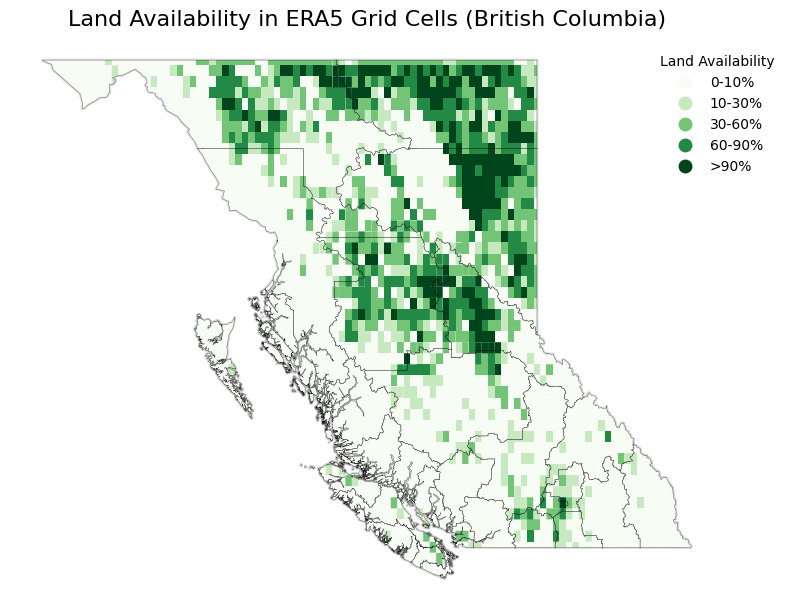

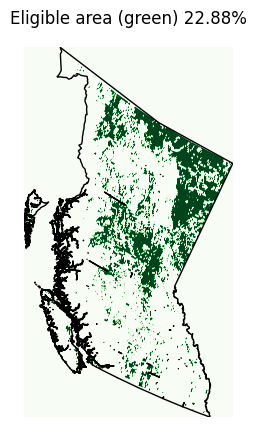

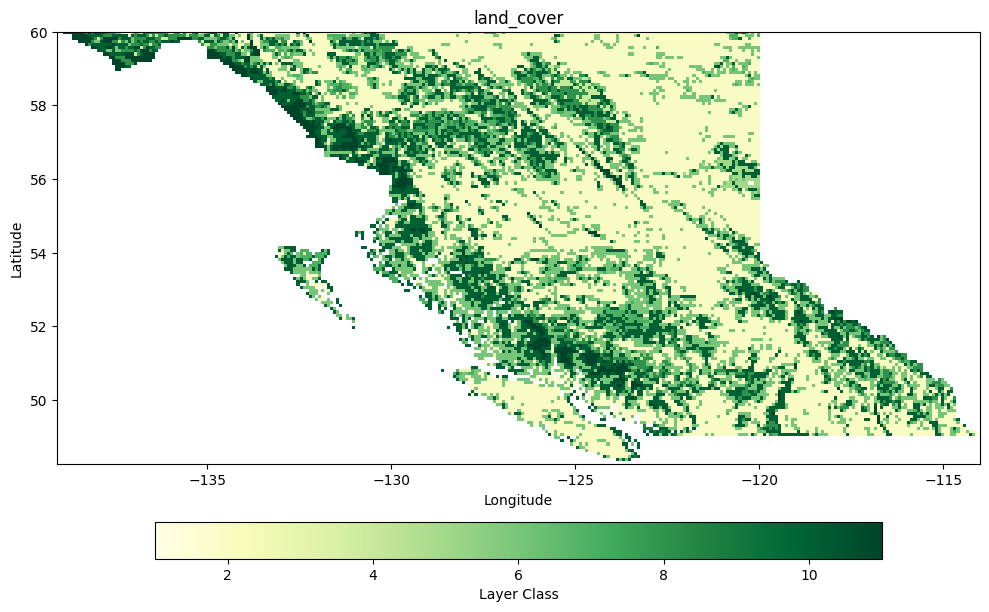

  └─> RES.gaez| Clipped Raster plot for British Columbia saved at: vis/misc/faocmb_2010_raster_BC.png


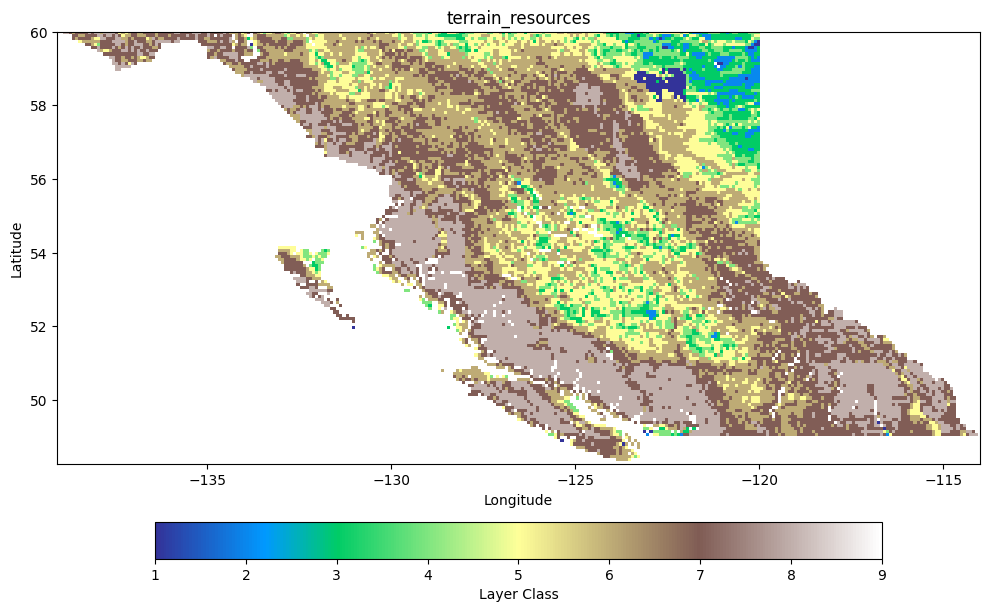

  └─> RES.gaez| Clipped Raster plot for British Columbia saved at: vis/misc/slpmed05_raster_BC.png


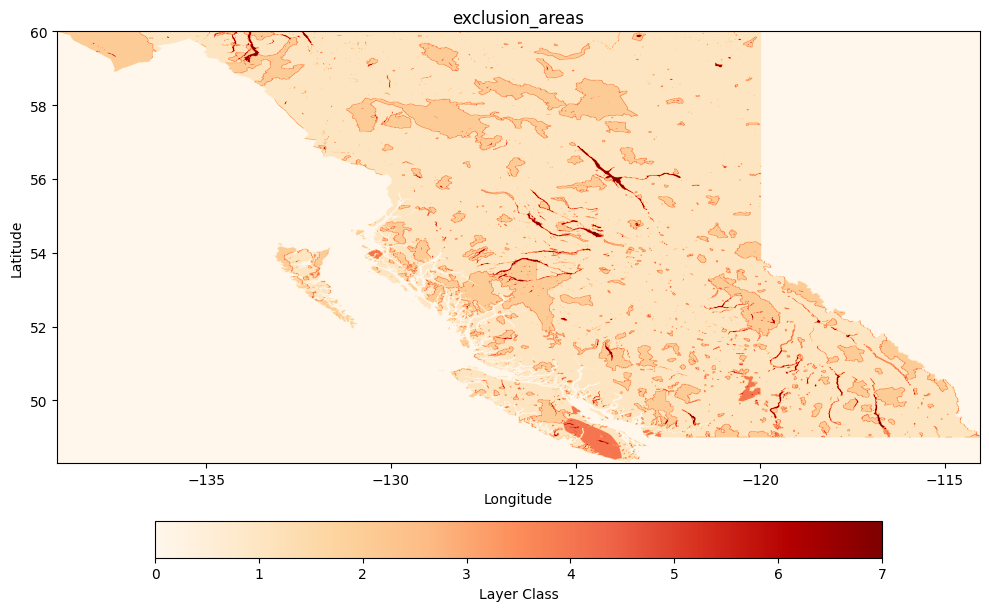

  └─> RES.gaez| Clipped Raster plot for British Columbia saved at: vis/misc/exclusion_2017_raster_BC.png


In [36]:
vis['land_avail_1']=RES_module.cell_processor.plot_ERAF5_grid_land_availability()
vis['land_avail_2']=RES_module.cell_processor.plot_excluder_land_availability()
for raster_type in RES_module.cell_processor.raster_types:
            vis[f'land_vis_gaez_raster_{raster_type['name']}']=RES_module.cell_processor.__clip_to_boundary_n_plot__(raster_type, RES_module.cell_processor.region_boundary.geometry,True)

# Explore the outputs from Store

In [37]:
from RES.hdf5_handler import DataHandler
res_store=DataHandler(f'data/store/resources_{province_code}.h5')

In [38]:
cells=res_store.from_store('cells')
boundary=res_store.from_store('boundary')
solar_clusters=res_store.from_store('clusters/solar')
wind_clusters=res_store.from_store('clusters/wind')
solar_clusters_ts=res_store.from_store('timeseries/clusters/solar')
wind_clusters_ts=res_store.from_store('timeseries/clusters/wind')

In [39]:
# wind_clusters[wind_clusters['lcoe']<=100].explore('potential_capacity')

# Playground for Top Site Selection

In [40]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_wind=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=50)

>>> Selecting TOP Sites to for 10 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Okanagan-Similkameen_1) originally had 4.02 GW potential capacity.To fit the maximum capacity investment of 10 GW, it has been adjusted to 0.52 GW

>>> Selecting TOP Sites to for 50 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 50 GW PV in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Thompson-Nicola_1) originally had 10.05 GW potential capacity.To fit the maximum capacity investment of 50 GW, it has been adjusted to 1.04 GW

In [41]:
RES_module.export_results('wind',
                    resource_clusters_wind,
                    cluster_timeseries_wind,)

wind clusters exported to :results


In [42]:
RES_module.export_results('solar',
                    resource_clusters_solar,
                    cluster_timeseries_solar,)

solar clusters exported to :results


In [43]:
# resource_clusters_solar.plot('potential_capacity',legend=True)
# resource_clusters_wind.plot('potential_capacity',legend=True)

# Visualize Results

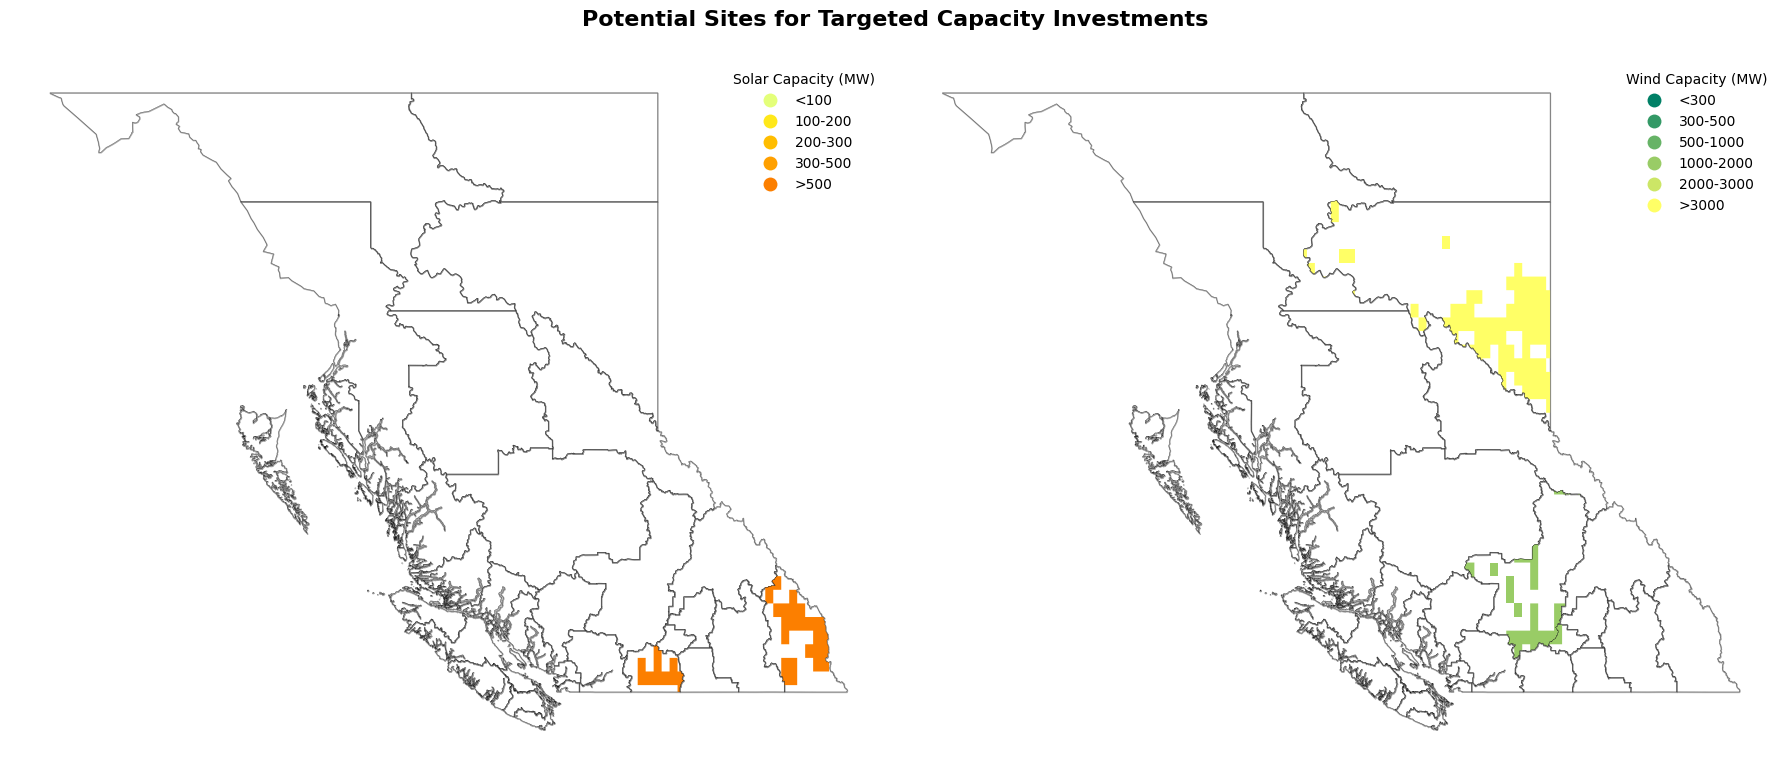

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset=1
# Ensure 'Region' is in the columns for both boundary and cells
if 'Region' not in boundary.columns:
    boundary = boundary.reset_index(inplace=True)

# Assign a number to each region
boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()

# Show the side-by-side plot

# plt.savefig('solar_wind_capacity_map.png',dpi=300)
plt.show()